# Quick tests outside of Test macro

In [1]:
using TestEnv
TestEnv.activate()

"/tmp/jl_ADEMSb/Project.toml"

In [3]:
using GalacticDynamics
using Test
using PythonCall
using CairoMakie
using BenchmarkTools
using ProfileView


pyimport("sys")."path".append("")
pyimport("sys")."path".append("../python")
accelerations_py = pyimport("accelerations")
au = pyimport("astropy.units")
gd = pyimport("gala.dynamics")
gp = pyimport("gala.potential")
gu = pyimport("gala.units")
gi = pyimport("gala.integrate")

Python: <module 'gala.integrate' from '/home/mmestre/.conda/envs/cosmos/lib/python3.11/site-packages/gala/integrate/__init__.py'>

#### Setting up initial conditions and potentials in both Gala and GalacticDynamics

In [130]:

t₁, t₂ = 0.0, 10.0
t_range = (t₁, t₂)
Δt = 0.01
n_max = (t₂-t₁)/Δt
x₀ = -50.0*SA[1,0,0]
v₀ = 200.0*SA[0,1,0]
m = 10.0^12*𝕦.m  # Msun
a = 20.0*𝕦.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
m_g = m/f(c)
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)

Python: <PhaseSpacePosition cartesian, dim=3, shape=()>

#### Orbit plot with Gala and GalacticDynamics


𝕤.ode = Vern9(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)
sol_gala.t[-1] = <py Quantity 10. Gyr>
sol.t[end] = 10.0
findmax(sol_diff) = (2.0317308946360413e-8, 974)


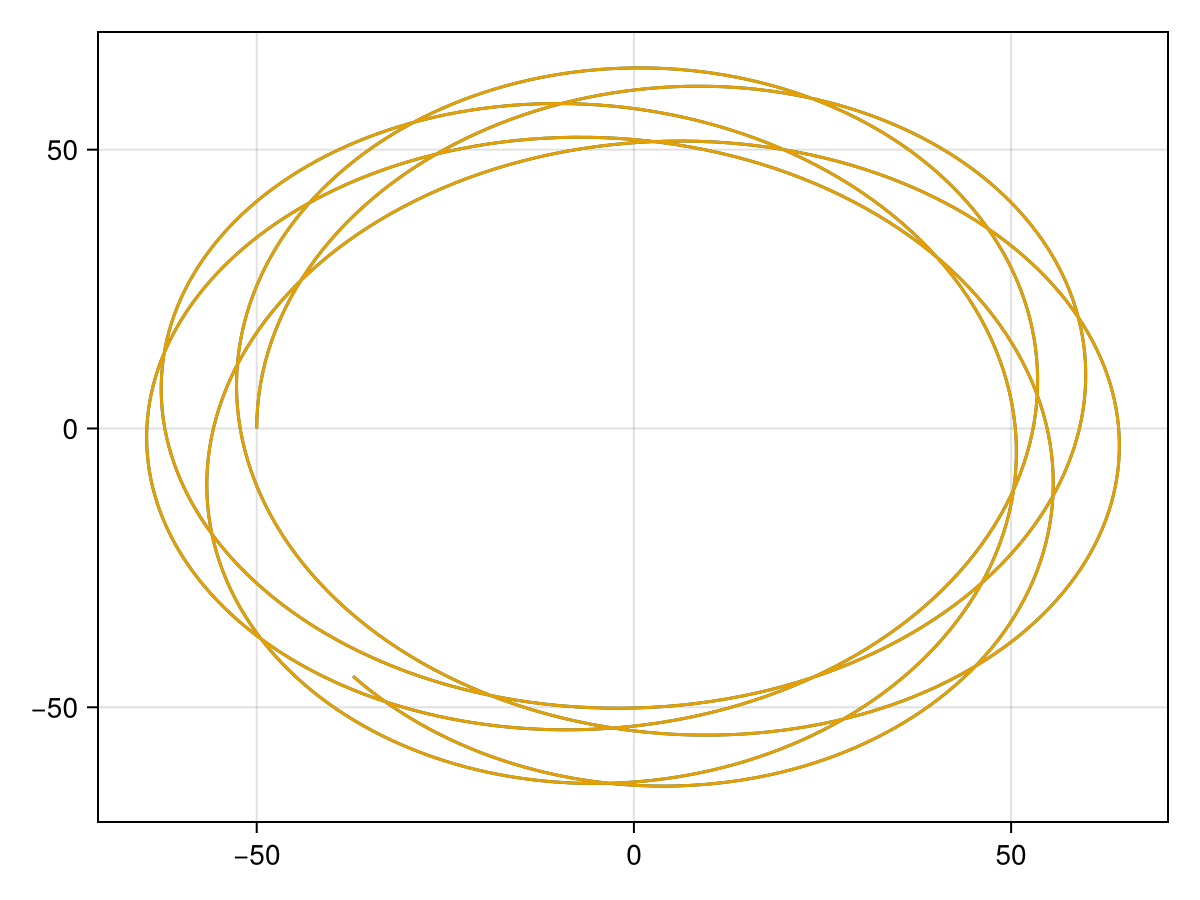

In [131]:
sol_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=t₂*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-12)))
sol = evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(;reltol=5.0e-12, saveat=Δt))

@show 𝕤.ode
@show sol_gala.t[-1]
@show sol.t[end]
orb_gala_x = pyconvert(Vector{Float64}, sol_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, sol_gala.y)
orb_x = sol.x[1,:]
orb_y = sol.x[2,:]
sol_diff = abs.(orb_gala_x-orb_x)
@show findmax(sol_diff)
lines(orb_gala_x,orb_gala_y)
lines!(orb_x,orb_y)
current_figure()



#### Precision test between Gala and GalacticDynamics
##### For the NFW
Adding `atol=0.5e-16` in both Gala and GalacticDynamics improves the precision by two orders of magnitude, only when `rtol` is already very small (`< 10^{-16}`).

In [145]:
orb₁ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-6)))
orb₂ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-11)))
orb₃ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-16, "atol"=>0.5e-16)))
orb₄ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-6, saveat=Δt))
orb₅ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Δt))
orb₆ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))
orb₇ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-6, saveat=Δt))
orb₈ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Δt))
orb₉ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16,
saveat=Δt))
@show orb₁.x[-1]  orb₂.x[-1]  orb₃.x[-1]
@show orb₄.x[1,end]  orb₅.x[1,end]  orb₆.x[1,end]
@show orb₇.x[1,end]  orb₈.x[1,end]  orb₉.x[1,end]
@show orb₄.x[1,end]-orb₁.x[-1].value  orb₅.x[1,end]-orb₂.x[-1].value  orb₆.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₁.x[-1].value  orb₈.x[1,end]-orb₂.x[-1].value  orb₉.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₄.x[1,end]  orb₈.x[1,end]-orb₅.x[1,end]  orb₉.x[1,end]-orb₆.x[1,end];

orb₁.x[-1] = <py Quantity -37.23718442 kpc>
orb₂.x[-1] = <py Quantity -37.23718442 kpc>
orb₃.x[-1] = <py Quantity -37.23718442 kpc>
orb₄.x[1, end] = -37.23740052058733
orb₅.x[1, end] = -37.23718442048122
orb₆.x[1, end] = -37.2371844195847
orb₇.x[1, end] = -37.2373930406552
orb₈.x[1, end] = -37.23718442103577
orb₉.x[1, end] = -37.237184419581304
orb₄.x[1, end] - (orb₁.x[-1]).value = <py -0.0002161010212518022>
orb₅.x[1, end] - (orb₂.x[-1]).value = <py -9.15143516522221e-10>
orb₆.x[1, end] - (orb₃.x[-1]).value = <py -1.8623325104272226e-11>
orb₇.x[1, end] - (orb₁.x[-1]).value = <py -0.00020862108912211852>
orb₈.x[1, end] - (orb₂.x[-1]).value = <py -1.4696937000735488e-09>
orb₉.x[1, end] - (orb₃.x[-1]).value = <py -1.5226930827338947e-11>
orb₇.x[1, end] - orb₄.x[1, end] = 7.479932129683675e-6
orb₈.x[1, end] - orb₅.x[1, end] = -5.545501835513278e-10
orb₉.x[1, end] - orb₆.x[1, end] = 3.396394276933279e-12


#### Precision test between Gala and GalacticDynamics
##### For the Miyamoto-Nagai disk

In [136]:
gp = pyimport("gala.potential")
gd= pyimport("gala.dynamics")
gu = pyimport("gala.units")
pot_mn = gp.MiyamotoNagaiPotential(m=2.5E11*au.Msun, a=6.5*au.kpc,b=0.26*au.kpc, units=gu.galactic)
w0 = gd.PhaseSpacePosition(pos=Py([11., 0., 0.2])*au.kpc, vel=Py([0., 200, 100])*au.km/au.s)
orb₁ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator)
orb₂ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
orb₃_c = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator,  cython_if_possible=true, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₃ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₄ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator)
orb₅ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
@show orb₁.x[-1] orb₂.x[-1] orb₃_c.x[-1] orb₃.x[-1]  orb₄.x[-1] orb₅.x[-1];

orb₁.x[-1] = <py Quantity 6.76980261 kpc>
orb₂.x[-1] = <py Quantity 6.76980261 kpc>
orb₃_c.x[-1] = <py Quantity 6.76980252 kpc>
orb₃.x[-1] = <py Quantity 6.76980252 kpc>
orb₄.x[-1] = <py Quantity 6.74183738 kpc>
orb₅.x[-1] = <py Quantity 6.74183738 kpc>


#### BenchmarkTools only tests memory consumption on the Julia side. The time is real as long as C is not working asynchronously.

In [22]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                    Integrator=gi.LeapfrogIntegrator,
                                    cython_if_possible=true)
                                    # Integrator_kwargs=Dict("rtol"=>5.0e-12, "atol"=>0.5e-12))


BenchmarkTools.Trial: 4384 samples with 1 evaluation.
 Range (min … max):  968.574 μs …  47.317 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):       1.045 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.130 ms ± 857.245 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁ ██                                                           
  ███████▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  969 μs           Histogram: frequency by time         1.74 ms <

 Memory estimate: 968 bytes, allocs estimate: 37.

#### Julia benchmarks

In [23]:
@benchmark evolve(pot, x₀, v₀, t_range, Tsit5(); options=ntSolverOptions(; reltol=5.0e-12, abstol=0.5e-12, saveat=Δt))

BenchmarkTools.Trial: 6287 samples with 1 evaluation.
 Range (min … max):  720.500 μs …   4.535 ms  ┊ GC (min … max): 0.00% … 74.39%
 Time  (median):     761.487 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   791.119 μs ± 104.096 μs  ┊ GC (mean ± σ):  0.17% ±  1.58%

  ▃▄ █▄▃▃                                                        
  ██▃████▆▅▆▅▅▅▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  720 μs           Histogram: frequency by time         1.09 ms <

 Memory estimate: 33.70 KiB, allocs estimate: 115.

In [83]:
@profilehtml evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-10, abstol=0.5e-10, saveat=Δt))

Orbit{Float64, Float64, Float64}
  t: Array{Float64}((1001,)) [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10.0]
  x: Array{Float64}((3, 1001)) [-50.0 -49.96840864903756 … -36.09545422697839 -37.23718617694323; -0.0 1.9995787836132937 … -45.7464219358443 -44.42341758130722; -0.0 0.0 … 0.0 0.0]
  v: Array{Float64}((3, 1001)) [0.0 6.317241735108024 … -115.85609611419706 -112.46644240122447; 200.0 199.8736491210614 … 130.21025038264216 134.37793690422737; 0.0 0.0 … 0.0 0.0]
